In [1]:
# Python : 3.6.13
# Numpy: 1.17.0
# pandas: 0.25.0
# matplotlib: 3.1.1
# scipy: 1.3.1
# scikit-learn: 0.20.0

import os, sys, glob
import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
#mpl.use('TKAgg',warn=False, force=True) #set MPL backend.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import pickle
import multiprocessing
import itertools
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import datashader as ds
from datashader.utils import export_image
from datashader.colors import *

## 使用する関数

In [6]:
# ファイルのLoading/saving
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
# デバック用
    with open(name + '.pkl', 'rb') as f:
# ファイル実行用
    # with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#------------------------------------------------------------------------------------------------------------ 
    
    

    
    
#------------------------------------------------------------------------------------------------------------ 

# プロットするための関数

#------------------------------------------------------------------------------------------------------------ 


def make_cmap(colors, position=None, bit =False): 
    #bit=Flaseはcolors = [(1,1,1), (101/255,236/255,101/255)] 
    #bit=Trueはcolors = [(255,255,255), (101,236,101)] →if bit: で形を変形
    bit_rgb = np.linspace(0,1,256) #0~1を256分割
    if position == None:
        position =np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
            
    if bit: #ここでcolorsをbit=Trueの場合と同じ形にする
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
            
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))
    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
#------------------------------------------------------------------------------------------------------------




# Customised histogram function to help plotting on log scale and other aspects (courtesy of Justin Bray)
def histvals(a, logmin=0.0, cumulative=False, **kwargs):  # **kwargsは辞書型で変数を入れることができる
  """Return x/y values for plotting a histogram."""

  if cumulative: # 累積に関して使うときにもう一度詳しくみた方がいい
    lims = kwargs.pop('bins', [a.min(), a.max()]) # ビンのサイズの最大値と最小値
    density = kwargs.pop('density', False) 
    assert not kwargs, 'Unprocessed kwargs in histvals.' # kwargsに使用されてない引数がある場合アラートする

    # Reduce length of array, if possible, by combining duplicate values.
    bins,counts = np.unique(a, return_counts=True)
    #counts, bins = np.histogram(a, **kwargs)

    bins = np.concatenate(( [lims[0]], bins, [lims[-1]] ))
    counts = np.concatenate(( [0], np.cumsum(counts) )) # np.cumsum(counts)で累積している

    if density:
      counts = counts*1./counts.max()
  else:
    counts, bins = np.histogram(a, **kwargs) #countには各ビンの度数 binsにはビンの境界値が入る

  x = np.concatenate( list(zip( bins[:-1], bins[1:] )) ) #軸が対数であるため、わかりやすく表示するため、x,yはどちらも値を2つずつ持ってる
  y = np.concatenate( list(zip( counts,    counts   )) )

  if not cumulative:
    x = np.concatenate(( [x[0]], x, [x[-1]] ))
    y = np.concatenate(( [0],    y,  [0]    ))

  # 負のあたいがあったとしてもうまくプロットされるようにloglim(非常に小さい正の値)にしてる
  if logmin:
    y = (y > 0)*y + (y <= 0)*logmin
  return x,y
#------------------------------------------------------------------------------------------------------------




def plot_basic_hists(df, place):
    bins = np.linspace(16, 26,150) #10~26の範囲を100分割し、それをビンのサイズとする
    linewidth = 1 #線の太さ
    plt.subplots(1, 1, figsize=(6,3.5)) #図の個数指定&サイズ指定

#     xvar='i_cmodel_mag' # 指定するカラム
    xvar='i_psfflux_mag' # 指定するカラム

    x, s = histvals(df[df['class']=='STAR'][xvar].values, bins=bins) #xにはビンのの値が２つずつ入ってる sにはヒストグラムの値が格納
    x, g = histvals(df[df['class']=='GALAXY'][xvar].values, bins=bins)
    x, q = histvals(df[df['class']=='QSO'][xvar].values, bins=bins)

    plt.plot(x, s, label='Stars: {0:.0f}'.format(np.sum(s)/2), color=star_c, linewidth=linewidth)
    plt.plot(x, g, label='Galaxies: {0:.0f}'.format(np.sum(g)/2), color=galaxy_c, linewidth=linewidth)
    plt.plot(x, q, label='Quasars: {0:.0f}'.format(np.sum(q)/2), color=quasar_c, linewidth=linewidth)

    plt.yscale('log')
#     plt.xlabel('cmode i magnitude')
    plt.xlabel('psf i magnitude', fontsize = 13)
    plt.ylabel('Number of sources', fontsize = 13)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.minorticks_on()
    plt.legend(frameon=False, fontsize = 12)
    plt.tight_layout()
#     plt.savefig('HSC_analysis_save/spec-hist-rmag.pdf')
    plt.savefig('HSC_analysis_save/'+place+'/spec-hist-rmag.pdf')
#------------------------------------------------------------------------------------------------------------





#------------------------------------------------------------------------------------------------------------ 

# 解析するための関数

#------------------------------------------------------------------------------------------------------------



def prepare_classifications(df, classes_pred):
    print('Preparing data...')
    # Each dict entry in df is a df, and df indices are integers. Do not use iloc, always use loc to consistently match back to original df.
    #この関数で分類の正誤をそれぞれの変数に分ける
    
    select_feat = 'features_test'
    select_class = 'classes_test'

    # df(辞書)に分類クラス(np array)を追加
    df['classes_pred'] = classes_pred


    # 間違った分類がされた天体
    missed_star = df[select_feat][ (df[select_class] != df['classes_pred']) & (df[select_class] == 'STAR') ]
    missed_quasar = df[select_feat][ (df[select_class] != df['classes_pred']) & (df[select_class] == 'QSO') ]
    missed_galaxy = df[select_feat][ (df[select_class] != df['classes_pred']) & (df[select_class] == 'GALAXY') ]

    # 正しい分類がされた天体
    correct_star = df[select_feat][ (df[select_class] == df['classes_pred']) & (df[select_class] == 'STAR') ]
    correct_quasar = df[select_feat][ (df[select_class] == df['classes_pred']) & (df[select_class] == 'QSO') ]
    correct_galaxy = df[select_feat][ (df[select_class] == df['classes_pred']) & (df[select_class] == 'GALAXY') ]

    # QSOと分類されたSTAR
    missed_star_as_quasar = df[select_feat][(df[select_class] != df['classes_pred']) & (df[select_class] == 'STAR') & (df['classes_pred'] == 'QSO')]
    # GALAXYと分類されたSTAR
    missed_star_as_galaxy = df[select_feat][(df[select_class] != df['classes_pred']) & (df[select_class] == 'STAR') & (df['classes_pred'] == 'GALAXY')]

    # STARと分類されたQSO
    missed_quasar_as_star = df[select_feat][(df[select_class] != df['classes_pred']) & (df[select_class] == 'QSO') & (df['classes_pred'] == 'STAR')]
    # GALAXYと分類されたQSO
    missed_quasar_as_galaxy = df[select_feat][(df[select_class] != df['classes_pred']) & (df[select_class] == 'QSO') & (df['classes_pred'] == 'GALAXY')]

    # STARと分類されたGALAXY
    missed_galaxy_as_star = df[select_feat][(df[select_class] != df['classes_pred']) & (df[select_class] == 'GALAXY') & (df['classes_pred'] == 'STAR')]
    # QSOと分類されたGALAXY
    missed_galaxy_as_quasar = df[select_feat][(df[select_class] != df['classes_pred']) & (df[select_class] == 'GALAXY') & (df['classes_pred'] == 'QSO')]
    

    return df, missed_star, missed_quasar, missed_galaxy, correct_star, correct_quasar, correct_galaxy, missed_star_as_quasar, missed_star_as_galaxy, missed_quasar_as_star, missed_quasar_as_galaxy, missed_galaxy_as_star, missed_galaxy_as_quasar
#------------------------------------------------------------------------------------------------------------ 




def plot_trainvsf1(f1_f, f1_f_sampleG, p_f, p_f_sampleG, r_f, r_f_sampleG, place):
    # プロットするmakerのサイズを指定
    markersize = 3
#     データの読み込み
#     psf
    f1scores = load_obj('HSC_ML_save/'+place+'/' + f1_f)
    f1scores_sampleG = load_obj('HSC_ML_save/'+place+'/' + f1_f_sampleG)
    precisions = load_obj('HSC_ML_save/'+place+'/' + p_f)
    precisions_sampleG = load_obj('HSC_ML_save/'+place+'/' + p_f_sampleG)
    recalls = load_obj('HSC_ML_save/'+place+'/' + r_f)
    recalls_sampleG = load_obj('HSC_ML_save/'+place+'/' + r_f_sampleG)
    
    train_range = f1scores[0] # train_rangeが0番目に入ってる。SDSS_ML.py train_vs_f1score()　より
    f1 = np.array(f1scores[1:]) # 0番目を無視する & numpy.ndarrayにする
    f1_sampleG = np.array(f1scores_sampleG[1:]) # 0番目を無視する & numpy.ndarrayにする
    precision = np.array(precisions)
    precision_sampleG = np.array(precisions_sampleG)
    recall = np.array(recalls)
    recall_sampleG = np.array(recalls_sampleG)

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7,9), sharex=True) #x軸を共有する3つの行と1つの列のグラフを作る
#     f, ax1 = plt.subplots(1, 1, figsize=(7,3.5))　　　　ax3をax1にしてf1score のみの図を出力

    plt.sca(ax1) #ax1(1番上の図)に関して設定することを宣言
    plt.plot(train_range, precision[:,0], label='Galaxy', marker='o', markersize=markersize, color=galaxy_c)  #numpy.ndarrayから値を取得しプロットする
    plt.plot(train_range, precision[:,1], label='Quasar', marker='o', markersize=markersize, color=quasar_c)
    plt.plot(train_range, precision[:,2], label='Star', marker='o', markersize=markersize, color=star_c)
    plt.plot(train_range, precision_sampleG[:,0], label='Galaxy (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=galaxy_c) # ls=':' は波線という事
    plt.plot(train_range, precision_sampleG[:,1], label='Quasar (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=quasar_c)
    plt.plot(train_range, precision_sampleG[:,2], label='Star (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=star_c)
    plt.ylabel('Precision')

    plt.ylim(top=1, bottom=0.57)

    plt.minorticks_on() #補助目盛りをつける
    # ↓whichはメイン目盛と補助メモリの両方
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=True)


    plt.sca(ax2) #ax2(2番目の図)に関して設定することを宣言
    plt.plot(train_range, recall[:,0], label='Galaxy', marker='o', markersize=markersize, color=galaxy_c)
    plt.plot(train_range, recall[:,1], label='Quasar', marker='o', markersize=markersize, color=quasar_c)
    plt.plot(train_range, recall[:,2], label='Star', marker='o', markersize=markersize, color=star_c)
    plt.plot(train_range, recall_sampleG[:,0], label='Galaxy (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=galaxy_c)
    plt.plot(train_range, recall_sampleG[:,1], label='Quasar (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=quasar_c)
    plt.plot(train_range, recall_sampleG[:,2], label='Star (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=star_c)
    plt.ylabel('Recall')
    plt.ylim(top=1, bottom=0.57)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=True)

    plt.sca(ax3) #ax3(3番目の図)に関して設定することを宣言
    plt.plot(train_range, f1[:,0], label='Galaxy', marker='o', markersize=markersize, color=galaxy_c)
    plt.plot(train_range, f1[:,1], label='Quasar', marker='o', markersize=markersize, color=quasar_c)
    plt.plot(train_range, f1[:,2], label='Star', marker='o', markersize=markersize, color=star_c)
    plt.plot(train_range, f1_sampleG[:,0], label='Galaxy (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=galaxy_c)
    plt.plot(train_range, f1_sampleG[:,1], label='Quasar (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=quasar_c)
    plt.plot(train_range, f1_sampleG[:,2], label='Star (trained on balanced classes)', marker='o', markersize=markersize, ls=':', color=star_c)
    plt.xlabel('Fraction of data trained on', fontsize = 13)
    plt.ylabel('F1-score', fontsize = 13)
    plt.minorticks_on()
    plt.ylim(top=1, bottom=0.57)
    plt.xlabel('Fraction of the training dataset trained on', fontsize = 13) #xラベルを定義
    plt.ylabel('F1-score', fontsize = 14)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)
    plt.tick_params(axis='y', which='both', right=True)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.legend(frameon=False, fontsize = 11) #ラインの名前をつける
    f.tight_layout() #レイアウトなどの乱れを正している
    f.subplots_adjust(wspace=0, hspace=0) # サブプロット間の水平方向（wspace）と垂直方向（hspace）のスペースを0にする。tight_layoutの後にする

#     cmodel
#     plt.savefig('HSC_analysis_save/Train-vs-PRF1.pdf')

#     psf
    plt.savefig('HSC_analysis_save/'+place+'/Train-vs-PRF1.pdf')
#------------------------------------------------------------------------------------------------------------



def plot_feature_ranking(pipeline, feature_names, place):
    clf=pipeline.steps[0][1] #get classifier used
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    feature_names_importanceorder=[]
    for f in range(len(indices)):
        #print("%d. feature %d (%f) {0}" % (f + 1, indices[f], importances[indices[f]]), feature_names[indices[f]])
        feature_names_importanceorder.append(str(feature_names[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,6))
    plt.bar(range(len(indices)), importances[indices],
           color='slategrey', yerr=std[indices], align="center")
    plt.xlim([-1, len(indices)])
    plt.xticks(range(len(indices)), feature_names_importanceorder, rotation='horizontal')
    plt.ylabel('Feature importance', fontsize=16)
    plt.ylim(bottom=-0.02)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=False)
    plt.tick_params(labelsize=14)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 13)
    plt.tight_layout()
#     cmodel
#     plt.savefig('HSC_analysis_save/feature-ranking.pdf')
#     psf
    plt.savefig('HSC_analysis_save/'+place+'/feature-ranking.pdf')
#------------------------------------------------------------------------------------------------------------



def plot_feature_hist(df, missed_star, missed_quasar, missed_galaxy, correct_star, correct_quasar, correct_galaxy,
missed_star_as_quasar, missed_star_as_galaxy, missed_quasar_as_star, missed_quasar_as_galaxy, missed_galaxy_as_star, missed_galaxy_as_quasar, place, plot_data_label='unknown'):
    print('Making feature histogram plot... features-.pdf')
    
    figsize = (10,3.5)
    linewidth = 1.2
    elinewidth = 0.5
    capthick = 0.5
    correct_capsize = 4
    missed_capsize = 1

    ## ------ ------ Star / Quasar  ------ ------
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[1,1.3,1]), figsize=figsize)


    # 星とクエーサーのcorrectとmissedを特徴量と等級のグラフにする
    plt.sca(ax1) 

    xlabels = ['g','r','i','z','y']
    plot_columns = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    # a : missed_star_as_quasar   b : missed_quasar_as_star
    a = plt.errorbar(plot_columns, df.loc[missed_star_as_quasar.index.values][plot_columns].mean(), yerr=df.loc[missed_star_as_quasar.index.values][plot_columns].std(), color=star_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed stars as quasars: {0}'.format(len(missed_star_as_quasar)), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df.loc[missed_quasar_as_star.index.values][plot_columns].mean(), yerr=df.loc[missed_quasar_as_star.index.values][plot_columns].std(), color=quasar_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed quasars as stars: {0}'.format(len(missed_quasar_as_star)), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    # correct_star_alとcorrect_quasar_allのプロット
    plt.errorbar(plot_columns, df.loc[correct_star.index.values][plot_columns].mean(), color=star_c, ls=correct_ls, yerr=df.loc[correct_star.index.values][[*plot_columns]].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct stars: {0}'.format(len(correct_star)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df.loc[correct_quasar.index.values][plot_columns].mean(), color=quasar_c, ls=correct_ls, yerr=df.loc[correct_quasar.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct quasars: {0}'.format(len(correct_quasar)), transform=trans+offset(+3))

#     plt.legend(frameon=False)
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name')
    plt.ylabel('Magnitude', fontsize = 13)
    plt.xticks(fontsize = 11)
    plt.yticks(np.arange(16, 25, step=2), fontsize = 10)
    plt.ylim(25,16)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()

    # ishape
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x1, y1, label='missed stars as quasars', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_star.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x2, y2, label='missed quasars as stars', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
#     plt.xlabel('ishape')
    plt.ylabel('Number', fontsize =13)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.tight_layout()
    plt.sca(ax3) 

    xlabels = ['g-r','r-i','i-z','z-y']
    plot_columns = ['g-r','r-i','i-z','z-y']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    # a : missed_star_as_quasar   b : missed_quasar_as_star
    a = plt.errorbar(plot_columns, df.loc[missed_star_as_quasar.index.values][plot_columns].mean(), yerr=df.loc[missed_star_as_quasar.index.values][plot_columns].std(), color=star_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed stars as quasars: {0}'.format(len(missed_star_as_quasar)), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df.loc[missed_quasar_as_star.index.values][plot_columns].mean(), yerr=df.loc[missed_quasar_as_star.index.values][plot_columns].std(), color=quasar_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed quasars as stars: {0}'.format(len(missed_quasar_as_star)), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    # correct_star_alとcorrect_quasar_allのプロット
    plt.errorbar(plot_columns, df.loc[correct_star.index.values][plot_columns].mean(), color=star_c, ls=correct_ls, yerr=df.loc[correct_star.index.values][[*plot_columns]].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct stars: {0}'.format(len(correct_star)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df.loc[correct_quasar.index.values][plot_columns].mean(), color=quasar_c, ls=correct_ls, yerr=df.loc[correct_quasar.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct quasars: {0}'.format(len(correct_quasar)), transform=trans+offset(+3))

    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name')
    plt.ylabel('Magnitude Diﬀerence', fontsize =13)
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 10)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()


    f.savefig('HSC_analysis_save/'+place+'/features-star-quasar'+plot_data_label+'.pdf')

    '''
    # psf_i - cmod_i　のヒストグラム. Resolved sourceかどうか?
    # dfから探す。これはresolvedを特徴量にしないときのことを考えて.
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x1, y1, label='missed stars as quasars', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_star.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x2, y2, label='missed quasars as stars', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('| PSF i - cmodel i | [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('HSC_analysis_save/psf/features-star-quasar'+plot_data_label+'.pdf')
    '''
    '''
    # Histogram of errors, high error sources classified worse?
    # Searching the original df because we don't use errors as a feature (they don't improve classification results)
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x1, y1, label='missed stars as quasars', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_star.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x2, y2, label='missed quasars as stars', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(top=2*10**5)
    plt.xlabel('PSF r error [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('star-quasar-'+plot_data_label+'.pdf')
    '''

    ## ------ ------ Star / Galaxy ------ ------

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[1,1.3,1]), figsize=figsize)
    
    # 星と銀河のcorrectとmissedを特徴量と等級のグラフにする
    plt.sca(ax1) 

    xlabels = ['g','r','i','z','y']
    plot_columns = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    a = plt.errorbar(plot_columns, df.loc[missed_star_as_galaxy.index.values][plot_columns].mean(), yerr=df.loc[missed_star_as_galaxy.index.values][plot_columns].std(), color=star_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed stars as galaxies: {0}'.format(len(missed_star_as_galaxy)), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df.loc[missed_galaxy_as_star.index.values][plot_columns].mean(), yerr=df.loc[missed_galaxy_as_star.index.values][plot_columns].std(), color=galaxy_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed galaxies as stars: {0}'.format(len(missed_galaxy_as_star)), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    plt.errorbar(plot_columns, df.loc[correct_star.index.values][plot_columns].mean(), color=star_c, ls=correct_ls, yerr=df.loc[correct_star.index.values][[*plot_columns]].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct stars: {0}'.format(len(correct_star)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df.loc[correct_galaxy.index.values][plot_columns].mean(), color=galaxy_c, ls=correct_ls, yerr=df.loc[correct_galaxy.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct galaxies: {0}'.format(len(correct_galaxy)), transform=trans+offset(+3))

#     plt.legend(frameon=False)
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name')
    plt.ylabel('Magnitude', fontsize =13)
    plt.xticks(fontsize = 11)
    plt.yticks(np.arange(16, 25, step=2), fontsize = 10)
    plt.ylim(25,16)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()



    # ishape
    plt.sca(ax2)

    x1, y1 = histvals(df.loc[missed_star_as_galaxy.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x1, y1, label='missed stars as galaxies', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_galaxy_as_star.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x2, y2, label='missed galaxies as stars', ls=missed_ls, color=galaxy_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_galaxy.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x4, y4, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
#     plt.xlabel('ishape')
    plt.ylabel('Number', fontsize =13)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.tight_layout()

    plt.sca(ax3) 

    xlabels = ['g-r','r-i','i-z','z-y']
    plot_columns = ['g-r','r-i','i-z','z-y']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    a = plt.errorbar(plot_columns, df.loc[missed_star_as_galaxy.index.values][plot_columns].mean(), yerr=df.loc[missed_star_as_galaxy.index.values][plot_columns].std(), color=star_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed stars as galaxies: {0}'.format(len(missed_star_as_galaxy)), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df.loc[missed_galaxy_as_star.index.values][plot_columns].mean(), yerr=df.loc[missed_galaxy_as_star.index.values][plot_columns].std(), color=galaxy_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed galaxies as stars: {0}'.format(len(missed_galaxy_as_star)), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    plt.errorbar(plot_columns, df.loc[correct_star.index.values][plot_columns].mean(), color=star_c, ls=correct_ls, yerr=df.loc[correct_star.index.values][[*plot_columns]].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct stars: {0}'.format(len(correct_star)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df.loc[correct_galaxy.index.values][plot_columns].mean(), color=galaxy_c, ls=correct_ls, yerr=df.loc[correct_galaxy.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct galaxies: {0}'.format(len(correct_galaxy)), transform=trans+offset(+3))

    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name')
    plt.ylabel('Magnitude Diﬀerence', fontsize =13)
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 10)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()
    f.savefig('HSC_analysis_save/'+place+'/features-star-galaxy'+plot_data_label+'.pdf')
    '''
    # psf_i - cmod_i　のヒストグラム. Resolved sourceかどうか?
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_galaxy.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x1, y1, label='missed stars as galaxies', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_galaxy_as_star.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x2, y2, label='missed galaxies as stars', ls=missed_ls, color=galaxy_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_galaxy.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x4, y4, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('| PSF i - cmodel i | [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('HSC_analysis_save/psf/features-star-galaxy'+plot_data_label+'.pdf')
    '''
    '''
    # Histogram of errors, high error sources classified worse?
    # Searching the original df because we don't use errors as a feature (they don't improve classification results)
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_galaxy.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x1, y1, label='missed stars as galaxies', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_galaxy_as_star.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x2, y2, label='missed galaxies as stars', ls=missed_ls, color=galaxy_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_galaxy.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x4, y4, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(top=2*10**5)
    plt.xlabel('PSF r error [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('star-galaxy_'+plot_data_label+'.pdf')
    '''

    ## ------ ------ Galaxy / Quasar ------ ------

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[1,1.3,1]), figsize=figsize)
    # 銀河とクエーサーのcorrectとmissedを特徴量と等級のグラフにする
    plt.sca(ax1) 

    xlabels = ['g','r','i','z','y']
    plot_columns = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    a = plt.errorbar(plot_columns, df.loc[missed_galaxy_as_quasar.index.values][plot_columns].mean(), yerr=df.loc[missed_galaxy_as_quasar.index.values][plot_columns].std(), color=galaxy_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed galaxies as quasars: {0}'.format(len(missed_galaxy_as_quasar)), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df.loc[missed_quasar_as_galaxy.index.values][plot_columns].mean(), yerr=df.loc[missed_quasar_as_galaxy.index.values][plot_columns].std(), color=quasar_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed quasars as galaxies: {0}'.format(len(missed_quasar_as_galaxy)), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    plt.errorbar(plot_columns, df.loc[correct_galaxy.index.values][plot_columns].mean(), color=galaxy_c, ls=correct_ls, yerr=df.loc[correct_galaxy.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct galaxies: {0}'.format(len(correct_galaxy)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df.loc[correct_quasar.index.values][plot_columns].mean(), color=quasar_c, ls=correct_ls, yerr=df.loc[correct_quasar.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct quasars: {0}'.format(len(correct_quasar)), transform=trans+offset(+3))

#     plt.legend(frameon=False)
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name')
    plt.ylabel('Magnitude', fontsize =13)
    plt.xticks(fontsize = 11)
    plt.yticks(np.arange(16, 25, step=2), fontsize = 10)
    plt.ylim(25,16)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()


    # ishape
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_galaxy_as_quasar.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x1, y1, label='missed galaxies as quasars', ls=missed_ls, color=galaxy_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_galaxy.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x2, y2, label='missed quasars as galaxies', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_galaxy.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x3, y3, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].ishape.values, bins=bins_i, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)

    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
#     plt.xlabel('ishape')
    plt.ylabel('Number', fontsize=13)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.tight_layout()



    plt.sca(ax3) 
    xlabels = ['g-r','r-i','i-z','z-y']
    plot_columns = ['g-r','r-i','i-z','z-y']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    a = plt.errorbar(plot_columns, df.loc[missed_galaxy_as_quasar.index.values][plot_columns].mean(), yerr=df.loc[missed_galaxy_as_quasar.index.values][plot_columns].std(), color=galaxy_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed galaxies as quasars: {0}'.format(len(missed_galaxy_as_quasar)), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df.loc[missed_quasar_as_galaxy.index.values][plot_columns].mean(), yerr=df.loc[missed_quasar_as_galaxy.index.values][plot_columns].std(), color=quasar_c, ls=missed_ls, capsize=missed_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='missed quasars as galaxies: {0}'.format(len(missed_quasar_as_galaxy)), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    plt.errorbar(plot_columns, df.loc[correct_galaxy.index.values][plot_columns].mean(), color=galaxy_c, ls=correct_ls, yerr=df.loc[correct_galaxy.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct galaxies: {0}'.format(len(correct_galaxy)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df.loc[correct_quasar.index.values][plot_columns].mean(), color=quasar_c, ls=correct_ls, yerr=df.loc[correct_quasar.index.values][plot_columns].std(), capsize=correct_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='correct quasars: {0}'.format(len(correct_quasar)), transform=trans+offset(+3))

    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name')
    plt.ylabel('Magnitude Diﬀerence', fontsize =13)
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 10)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()
    f.savefig('HSC_analysis_save/'+place+'/features-galaxy-quasar'+plot_data_label+'.pdf')

    '''
    # psf_i - cmod_i　のヒストグラム. Resolved sourceかどうか?
    plt.sca(ax2)
    bins=bins_mag
    x1, y1 = histvals(df.loc[missed_galaxy_as_quasar.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x1, y1, label='missed galaxies as quasars', ls=missed_ls, color=galaxy_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_galaxy.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x2, y2, label='missed quasars as galaxies', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_galaxy.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x3, y3, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('| PSF i - cmodel i | [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('HSC_analysis_save/psf/features-galaxy-quasar'+plot_data_label+'.pdf')
    '''
    '''
    # Histogram of errors, high error sources classified worse?
    # Searching the original df because we don't use errors as a feature (they don't improve classification results)
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_galaxy_as_quasar.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x1, y1, label='missed galaxies as quasars', ls=missed_ls, color=galaxy_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_galaxy.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x2, y2, label='missed quasars as galaxies', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_galaxy.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x3, y3, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(top=2*10**5)
    plt.xlabel('PSF r error [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('galaxy-quasar_'+plot_data_label+'.pdf')
    '''
#------------------------------------------------------------------------------------------------------------



def plot_probs_hist(df, missed_star, missed_quasar, missed_galaxy, correct_star, correct_quasar, correct_galaxy, missed_star_as_quasar, missed_star_as_galaxy, missed_quasar_as_star, missed_quasar_as_galaxy, missed_galaxy_as_star, missed_galaxy_as_quasar, place, plot_data_label='unknown'):

    # --- --- --- histgoram of probabilities for correct/missed sources --- ---  ---

    # two plots side by side
    f, axs = plt.subplots(1, 2, figsize=(10,3.5), sharey=False, sharex=False)
    bins_prob = np.linspace(0,1,50)

    plt.sca(axs[0])
    density=False
    cumulative=False
    # correct onjects
    x1, y1 = histvals(df.loc[correct_galaxy.index.values].prob_g.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='correct galaxies : {}'.format(len(df.loc[correct_galaxy.index.values].prob_g)), ls=correct_ls, color=galaxy_c)
    x1, y1 = histvals(df.loc[correct_star.index.values].prob_s.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='correct stars : {}'.format(len(df.loc[correct_star.index.values].prob_s)), ls=correct_ls, color=star_c)
    x1, y1 = histvals(df.loc[correct_quasar.index.values].prob_q.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='correct quasars : {}'.format(len(df.loc[correct_quasar.index.values].prob_q)), ls=correct_ls, color=quasar_c)

    '''
    # missed objects combined
    x1, y1 = histvals(df.loc[missed_galaxy.index.values].prob_g.values, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed galaxies', ls=missed_ls, color=galaxy_c)
    x1, y1 = histvals(df.loc[missed_star.index.values].prob_s.values, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed stars', ls=missed_ls, color=star_c)
    x1, y1 = histvals(df.loc[missed_quasar.index.values].prob_q.values, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed quasars', ls=missed_ls, color=quasar_c)
    '''

    # missed sources
    x1, y1 = histvals(df.loc[missed_galaxy_as_star.index.values].prob_g.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed galaxies as stars : {}'.format(len(df.loc[missed_galaxy_as_star.index.values].prob_g)), ls=missed_ls, color=galaxy_c)
    x1, y1 = histvals(df.loc[missed_galaxy_as_quasar.index.values].prob_g.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed galaxies as quasars : {}'.format(len(df.loc[missed_galaxy_as_quasar.index.values].prob_g)), ls=missed_ls, color=galaxy_c2)

    x1, y1 = histvals(df.loc[missed_star_as_galaxy.index.values].prob_s.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed stars as galaxies : {}'.format(len(df.loc[missed_star_as_galaxy.index.values].prob_s)), ls=missed_ls, color=star_c)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].prob_s.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed stars as quasars : {}'.format(len(df.loc[missed_star_as_quasar.index.values].prob_s)), ls=missed_ls, color=star_c2)

    x1, y1 = histvals(df.loc[missed_quasar_as_star.index.values].prob_q.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed quasars as stars : {}'.format(len(df.loc[missed_quasar_as_star.index.values].prob_q)), ls=missed_ls, color=quasar_c)
    x1, y1 = histvals(df.loc[missed_quasar_as_galaxy.index.values].prob_q.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed quasars as galaxies : {}'.format(len(df.loc[missed_quasar_as_galaxy.index.values].prob_q)), ls=missed_ls, color=quasar_c2)

    plt.xlabel('Random forest classification probability', fontsize = 13)
    plt.ylabel('Number of sources', fontsize = 13)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.minorticks_on()
    axs[0].tick_params(which='both', right=True)
    plt.yscale('log')
#     plt.legend(frameon=False, fontsize=8)


    plt.sca(axs[1])
    density=True
    cumulative=True
    # correct sources
    x1, y1 = histvals(df.loc[correct_galaxy.index.values].prob_g.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='correct galaxies', ls=correct_ls, color=galaxy_c)
    x1, y1 = histvals(df.loc[correct_star.index.values].prob_s.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='correct stars', ls=correct_ls, color=star_c)
    x1, y1 = histvals(df.loc[correct_quasar.index.values].prob_q.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='correct quasars', ls=correct_ls, color=quasar_c)

    # missed sources
    x1, y1 = histvals(df.loc[missed_galaxy_as_star.index.values].prob_g.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed galaxies as stars', ls=missed_ls, color=galaxy_c)
    x1, y1 = histvals(df.loc[missed_galaxy_as_quasar.index.values].prob_g.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed galaxies as quasars', ls=missed_ls, color=galaxy_c2)

    x1, y1 = histvals(df.loc[missed_star_as_galaxy.index.values].prob_s.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed stars as galaxies', ls=missed_ls, color=star_c)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].prob_s.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed stars as quasars', ls=missed_ls, color=star_c2)

    x1, y1 = histvals(df.loc[missed_quasar_as_star.index.values].prob_q.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed quasars as stars', ls=missed_ls, color=quasar_c)
    x1, y1 = histvals(df.loc[missed_quasar_as_galaxy.index.values].prob_q.values, cumulative=cumulative, bins=bins_prob, density=density)
    plt.plot(x1, y1, label='missed quasars as galaxies', ls=missed_ls, color=quasar_c2)


    plt.xlabel('Random forest classification probability', fontsize = 13)
    plt.ylabel('Fraction of sources', fontsize = 13)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.minorticks_on()
    axs[1].tick_params(which='both', right=True)
    #plt.yscale('log')
    #plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig('HSC_analysis_save/'+place+'/probabilities-hist'+plot_data_label+'.pdf')
#------------------------------------------------------------------------------------------------------------



def plot_probs_hexscatter(df, missed_star, missed_quasar, missed_galaxy, correct_star, correct_quasar, correct_galaxy, missed_star_as_quasar, missed_star_as_galaxy, missed_quasar_as_star, missed_quasar_as_galaxy, missed_galaxy_as_star, missed_galaxy_as_quasar, place, plot_data_label='unknown'):
    #mpl.rcParams.update({'font.size': 8})
    # --- --- --- scatter plot of all sources with histogram overlaid ---  ---  ---

    # Select plot values:
    val = 'i_psfflux_mag'
    #val = 'feature_1D'

    #colors_g2 = [(1,1,1), (0/255,0/255,0/255)] # black
    #cmap_g2 = make_cmap(colors_g2)
    #colors_q2 = [(1,1,1), (0/255,0/255,255/255)] # blue
    #cmap_q2 = make_cmap(colors_q2)
    #colors_s2 = [(1,1,1), (255/255,165/255,0/255)] # orange
    #cmap_s2 = make_cmap(colors_s2)

    gridsize = (60,30) # getting the exact ratio is not trivial... trial and error to get symmetrical hexagons, ensuring binsize is 0.01.
    marker_c = '.'
    marker_m = '.'
    linewidths=0.01 # reduce hexbin linewidths to prevent overlapping
    linewidth=1 # histogram linewidth
    s=0.03 # missed objects scatter plot marker size
    sleg = 13 # legend marker size
    density = False
    f, axs = plt.subplots(1, 3, figsize=(10,4.5), sharey=False, sharex=False)
    #yrange = [-0.02,1.20] # if figsize = 10,5 (to acommodate legend)
    yrange = [-0.02,1.22] # if figsize = 10,4.5

    # correct galaxies
    plt.sca(axs[0])
    bins = np.linspace(15,25,150) # bins for galaxies (diff for each type)
    x1 = df.loc[correct_galaxy.index.values][val].values
    y1 = df.loc[correct_galaxy.index.values].prob_g.values
    #plt.scatter(x1, y1, label='correct galaxies', marker=marker_c, color=galaxy_c, s=s)
    plt.hexbin(x1, y1, gridsize=gridsize, bins='log', linewidths=linewidths, cmap=cmap_g)
    im=plt.hexbin(x1, y1, gridsize=gridsize, bins='log', linewidths=linewidths, cmap=cmap_g) # for colourbar axs later
    #plt.colorbar(orientation='horizontal', pad=0.01, aspect=40, shrink=1.0, panchor=(0.5, 2.0), anchor=(0.5,1.0))
    x1, y1 = histvals(df.loc[correct_galaxy.index.values][val].values, bins=bins, density=density)
    plt.plot(x1, y1/y1.max(), label='Histogram of correct galaxies', ls=correct_ls, linewidth=linewidth, color=galaxy_c)
    # missed galaxies
    x2 = df.loc[missed_galaxy.index.values][val].values
    y2 = df.loc[missed_galaxy.index.values].prob_g.values
    plt.scatter(x2, y2, marker=marker_m, color="black", s=s) # missed galaxies
    #plt.hexbin(x2, y2, gridsize=gridsize, bins='log', linewidths=linewidths, label='missed galaxies', cmap=cmap_g2)
    x2, y2 = histvals(df.loc[missed_galaxy.index.values][val].values, bins=bins, density=density)
    plt.plot(x2, y2/(0.1*y1.max()), label='Histogram of missed galaxies (x10)', ls=missed_ls, linewidth=linewidth, color=galaxy_c)

    plt.xlim(15,25)
    plt.xticks(np.arange(15, 25+1, step=2))
    axs[0].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    plt.ylim(yrange[0], yrange[1])
    plt.yticks(np.arange(0, 1.01, step=0.1))
    axs[0].yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(0, 1.01, step=0.02))) # urgh, force them.
    #axs[0].yaxis.set_tick_params(which='minor', left=True)
    plt.scatter(0,0, marker='h', color=galaxy_c, s=sleg, label='Correct galaxies (hexbin colour scale)')
    plt.scatter(0,0, marker='o', facecolors='none', color="black", s=sleg, label='Missed galaxies')
    plt.legend(frameon=False, fontsize=6, loc='upper left')
    plt.ylabel('Random forest classification probability')
    # ticks on both sides of plot
    plt.tick_params(axis='y', which='both', right=True)
    plt.xlabel('PSF i magnitude')

    ax_divider = make_axes_locatable(axs[0])
    # add an axes above the main axes.
    cax = ax_divider.append_axes("top", size="3%", pad="1%")
    cb = colorbar(im, cax=cax, orientation="horizontal")
    # change tick position to top. Tick position defaults to bottom and overlaps the image
    cax.xaxis.set_ticks_position("top")
    #cax.xaxis.set_tick_params(labelsize='small', labelleft='off')
    cax.axes.get_yaxis().set_visible(False)
    cax.tick_params(labelsize=6)
    labels = cax.get_xticks().tolist()
    labels[0] = '1' # first entry is too small and isn't plotted. force at 1 to prevent log10 inf warnings.
    labels = ['$10^{0:.0f}$'.format(np.log10(int(i))) for i in labels] # convert labels into scientific notation with rasied exponents. ignore first entry as it's not plotted.
    labels[1] = '0' # set second entry to zero (it's a v small value)
    cax.set_xticklabels(labels)
    #cax.ticklabel_format(style='sci')
    #cax.get_yaxis().set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
    #f = ticker.ScalarFormatter(useOffset=False, useMathText=True)
    #cax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(f._formatSciNotation('%.0e' % x))))
    plt.minorticks_on()


    # correct quasars
    plt.sca(axs[1])
    bins = np.linspace(15,25,150)
    x1 = df.loc[correct_quasar.index.values][val].values
    y1 = df.loc[correct_quasar.index.values].prob_q.values
    #plt.scatter(x1, y1, label='correct quasars', marker=marker_c, color=quasar_c, s=s)
    plt.hexbin(x1, y1, gridsize=gridsize, bins='log', linewidths=linewidths, cmap=cmap_q)
    im = plt.hexbin(x1, y1, gridsize=gridsize, bins='log', linewidths=linewidths, cmap=cmap_q) # for cbar
    x1, y1 = histvals(df.loc[correct_quasar.index.values][val].values, bins=bins, density=density)
    plt.plot(x1, y1/y1.max(), label='histogram of correct quasars', ls=correct_ls, linewidth=linewidth, color=quasar_c)
    # missed quasars
    x2 = df.loc[missed_quasar.index.values][val].values
    y2 = df.loc[missed_quasar.index.values].prob_q.values
    plt.scatter(x2, y2, marker=marker_m, color="black", s=s)
    x2, y2 = histvals(df.loc[missed_quasar.index.values][val].values, bins=bins, density=density)
    plt.plot(x2, y2/y1.max(), label='histogram of missed quasars', ls=missed_ls, linewidth=linewidth, color=quasar_c)
    plt.xlabel('PSF i magnitude')
    # ticks on both sides of plot
    plt.tick_params(axis='y', which='both', right=True)

    plt.xlim(15,25)
    plt.xticks(np.arange(15, 25+1, step=2))
    axs[1].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    plt.ylim(yrange[0], yrange[1])
    plt.yticks(np.arange(0, 1.01, step=0.1))
    axs[1].yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(0, 1.01, step=0.02)))
    #axs[1].yaxis.set_tick_params(which='minor', left=True)
    plt.scatter(0,0, marker='h', color=quasar_c, s=sleg, label='Correct quasars (hexbin colour scale)')
    plt.scatter(0,0, marker='o', facecolors='none', color="black", s=sleg, label='Missed quasars')
    plt.legend(frameon=False, fontsize=6, loc='upper left')
    # ticks on both sides of plot
    plt.tick_params(axis='y', which='both', right=True)
    plt.xlabel('PSF i magnitude')

    ax_divider = make_axes_locatable(axs[1])
    # add an axes above the main axes.
    cax = ax_divider.append_axes("top", size="3%", pad="1%")
    cb = colorbar(im, cax=cax, orientation="horizontal")
    # change tick position to top. Tick position defaults to bottom and overlaps the image
    cax.xaxis.set_ticks_position("top")
    #cax.xaxis.set_tick_params(labelsize='small', labelleft='off')
    cax.axes.get_yaxis().set_visible(False)
    cax.tick_params(labelsize=6)
    labels = cax.get_xticks().tolist()
    labels[0] = '1' # first entry is too small and isn't plotted. force at 1 to prevent log10 inf warnings.
    labels = ['$10^{0:.0f}$'.format(np.log10(int(i))) for i in labels] # convert labels into scientific notation with rasied exponents. ignore first entry as it's not plotted.
    labels[1] = '0' # set second entry to zero (it's a v small value)
    cax.set_xticklabels(labels)
    plt.minorticks_on()



    # correct stars
    plt.sca(axs[2])
    bins = np.linspace(15,25,150)
    #gridsize = (210,30) # larger gridsize for stars since xrange is larger
    x1 = df.loc[correct_star.index.values][val].values
    y1 = df.loc[correct_star.index.values].prob_s.values
    #plt.scatter(x1, y1, label='correct stars', marker=marker_c, color=star_c, s=s)
    plt.hexbin(x1, y1, gridsize=gridsize, bins='log', linewidths=linewidths, cmap=cmap_s)
    im = plt.hexbin(x1, y1, gridsize=gridsize, bins='log', linewidths=linewidths, cmap=cmap_s) # for cbar
    x1, y1 = histvals(df.loc[correct_star.index.values][val].values, bins=bins, density=density)
    plt.plot(x1, y1/y1.max(), label='Histogram of correct stars', ls=correct_ls, linewidth=linewidth, color=star_c)
    # missed stars
    x2 = df.loc[missed_star.index.values][val].values
    y2 = df.loc[missed_star.index.values].prob_s.values
    plt.scatter(x2, y2, marker=marker_m, color="black", s=s)
    x2, y2 = histvals(df.loc[missed_star.index.values][val].values, bins=bins, density=density)
    plt.plot(x2, y2/y1.max(), label='Histogram of missed stars', ls=missed_ls, linewidth=linewidth, color=star_c)

    plt.xlim(15,25)
    plt.xticks(np.arange(15, 25+1, step=2))
    axs[2].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    plt.ylim(yrange[0], yrange[1])
    plt.yticks(np.arange(0, 1.01, step=0.1))
    axs[2].yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(0, 1.01, step=0.02)))
    #axs[2].yaxis.set_tick_params(which='minor', left=True)
    plt.scatter(0,0, marker='h', color=star_c, s=sleg, label='Correct stars (hexbin colour scale)')
    plt.scatter(0,0, marker='o', facecolors='none', color="black", s=sleg, label='Missed stars')
    plt.legend(frameon=False, fontsize=6, loc='upper left')
    #plt.ylabel('Random forest classification probability')
    # ticks on both sides of plot
    plt.tick_params(axis='y', which='both', right=True)
    plt.xlabel('PSF i magnitude')

    ax_divider = make_axes_locatable(axs[2])
    # add an axes above the main axes.
    cax = ax_divider.append_axes("top", size="3%", pad="1%")
    cb = colorbar(im, cax=cax, orientation="horizontal")
    # change tick position to top. Tick position defaults to bottom and overlaps the image
    cax.xaxis.set_ticks_position("top")
    #cax.xaxis.set_tick_params(labelsize='small', labelleft='off')
    cax.axes.get_yaxis().set_visible(False)
    cax.tick_params(labelsize=6)
    labels = cax.get_xticks().tolist()
    labels[0] = '1' # first entry is too small and isn't plotted. force at 1 to prevent log10 inf warnings.
    labels = ['$10^{0:.0f}$'.format(np.log10(int(i))) for i in labels] # convert labels into scientific notation with rasied exponents. ignore first entry as it's not plotted.
    labels[1] = '0' # set second entry to zero (it's a v small value)
    cax.set_xticklabels(labels)
    plt.minorticks_on()

#     #plt.tight_layout() # this doesn't work with the axs divider i used. don't use tight_layout.
    plt.savefig('HSC_analysis_save/'+place+'/hexbin-prob-imag'+plot_data_label+'.pdf', bbox_inches='tight', dpi=700)
    #plt.savefig('prob_1Dfeature_'+plot_data_label+'.pdf')



## 色やパラメーターの設定

In [7]:
# Matplotlibのフォントサイズと図のDPIを設定
mpl.rcParams.update({'font.size': 8}) # フォントサイズを8
mpl.rcParams.update({'figure.dpi': 100}) # 図のDPI（ドット数/インチ）を100

# 色の設定
quasar_c = 'hotpink'
star_c = 'dodgerblue'
galaxy_c = (101/255,236/255,101/255) # alexgreen

quasar_c2 = 'black' # plot_probs_histで使用
star_c2 = 'blue' # plot_probs_histで使用
galaxy_c2 = 'orange' # plot_probs_histで使用

# カラーマップの指定
colors_g = [(1,1,1), (101/255,236/255,101/255)] # springgreen
cmap_g = make_cmap(colors_g)
colors_q = [(1,1,1), (255/255,105/255,180/255)]
cmap_q = make_cmap(colors_q)
colors_s = [(1,1,1), (30/255,144/255,255/255)]
cmap_s = make_cmap(colors_s)

correct_ls = '-' # 実線
missed_ls = '--' # 破線
linewidth = 1# 線の太さ
rotation = 0 # テキストやラベルの回転

# Histogram parameters
density = False # 密度ヒストグラムか
cumulative = False #累積ヒストグラムか

# resolved psf_i - cmodel_i のビン
bins_res = 10 ** np.linspace(np.log10(1e-5), np.log10(10), 100)
# ishape のビン
bins_i = 10 ** np.linspace(np.log10(1), np.log10(1000), 100)
# magnitude range のビン
bins_mag = np.linspace(11,24,75)
# magnitude errors のビン
bins_err = 10 ** np.linspace(np.log10(1e-4), np.log10(100), 100)

linewidth_hist = 0.5 # 線の幅
bins_mag_hist_ugriz = np.linspace(12,28,150) # UGRIZ波長範囲の等級のビンの範囲

## データの読み込み

In [8]:
# 特徴
# cmodel = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
psf = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']
color = ['g-r', 'r-i', 'i-z', 'z-y']

feature_columns = psf + ['ishape'] + color
feature_labels = ['g','r','i','z','y', '$\mathrm{ishape}$', 'g-r', 'r-i', 'i-z', 'z-y']

place = "psf_ishape_color"

print('Loading data...')
pipeline = load_obj('HSC_ML_save/'+place+'/rf_pipeline')
data_prep_dict_all = load_obj('HSC_ML_save/'+place+'/data_prep_dict_all')
classes_pred_all = load_obj('HSC_ML_save/'+place+'/classes_pred_all')
df = load_obj('HSC_ML_save/'+place+'/df_spec_classprobs')

Loading data...


## 解析

Preparing data...
Making feature histogram plot... features-.pdf
GALAXY 99以上: 69.38%  GALAXY 90以上:97.01%
STAR 99以上: 52.34%  STAR 90以上:81.32%
QSO 99以上: 28.72%  QSO 90以上:79.66%


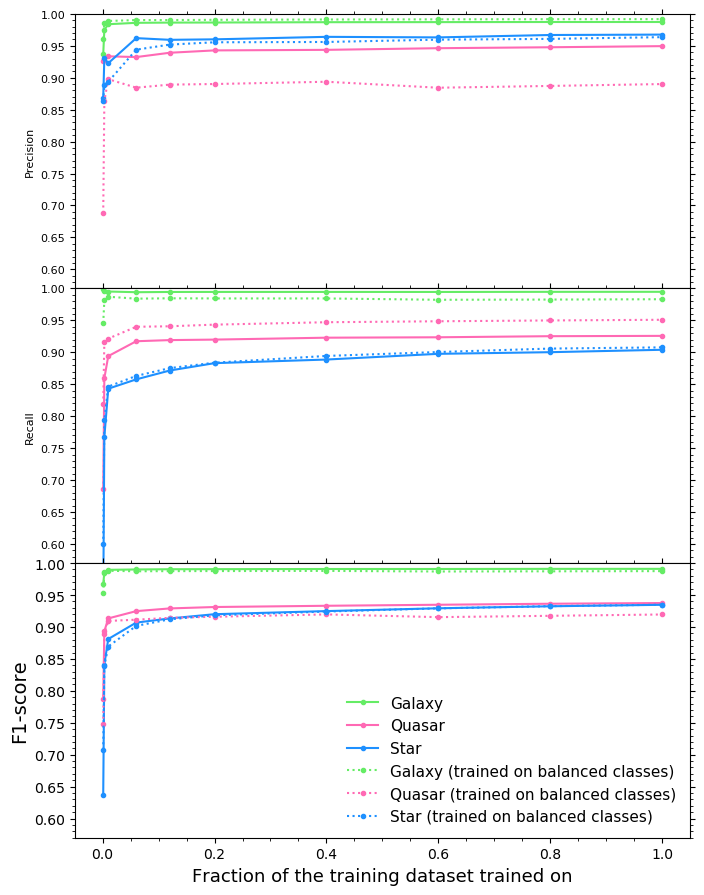

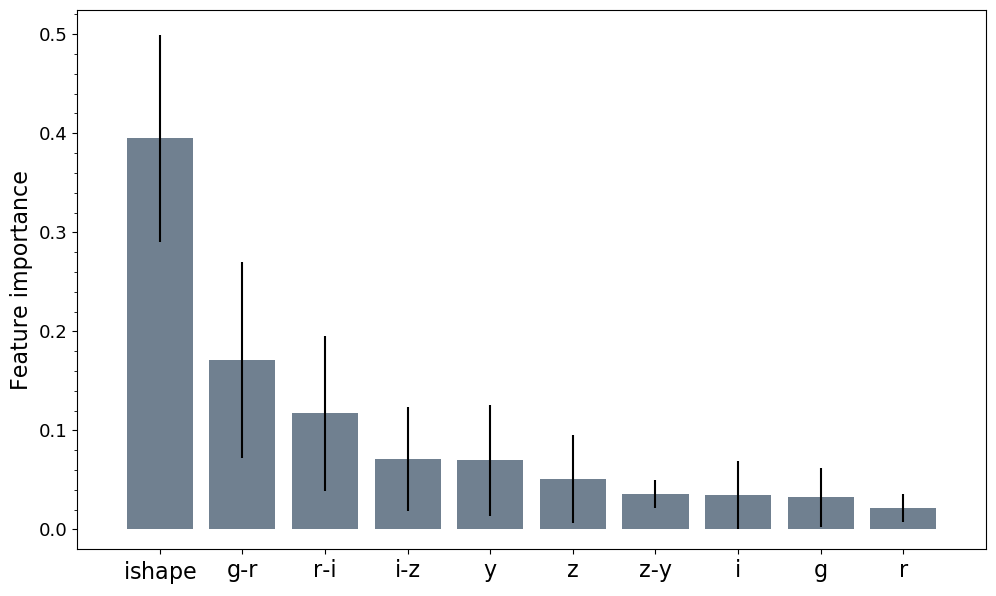

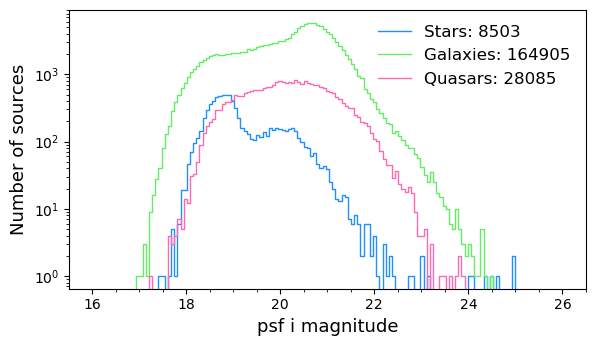

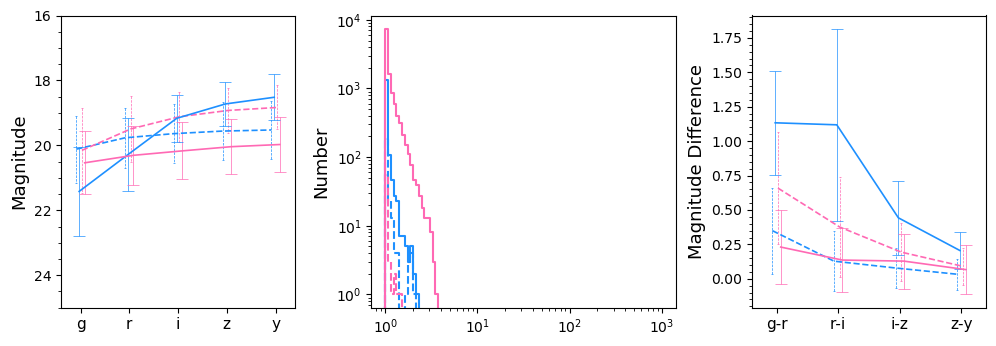

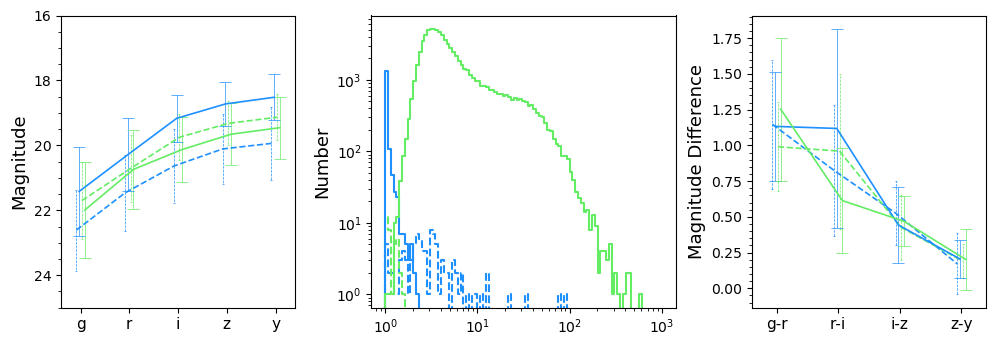

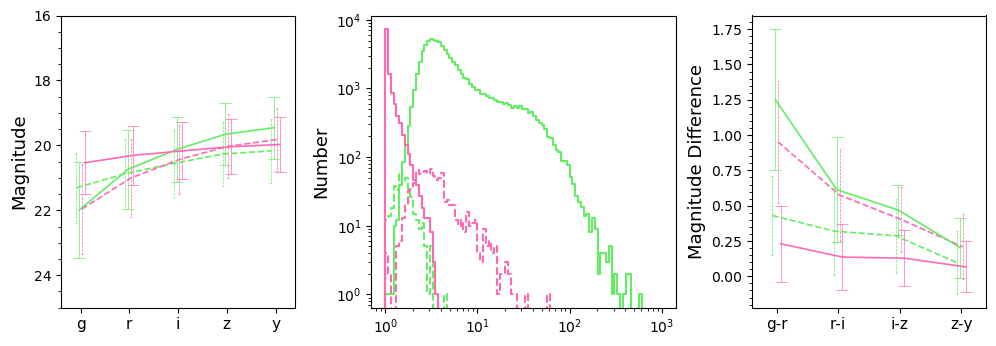

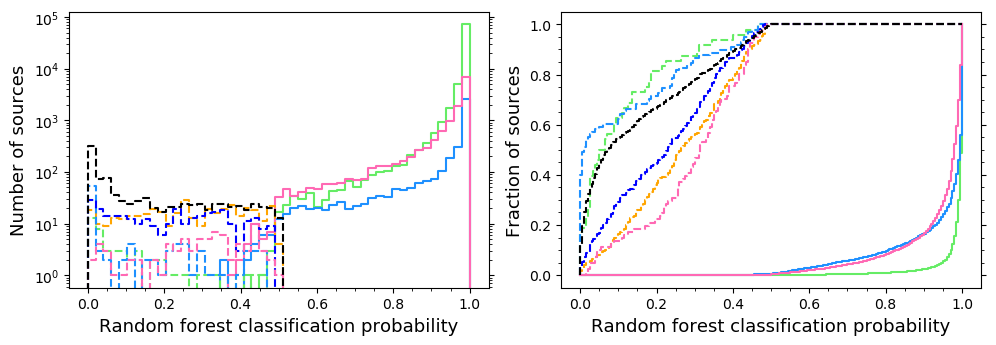

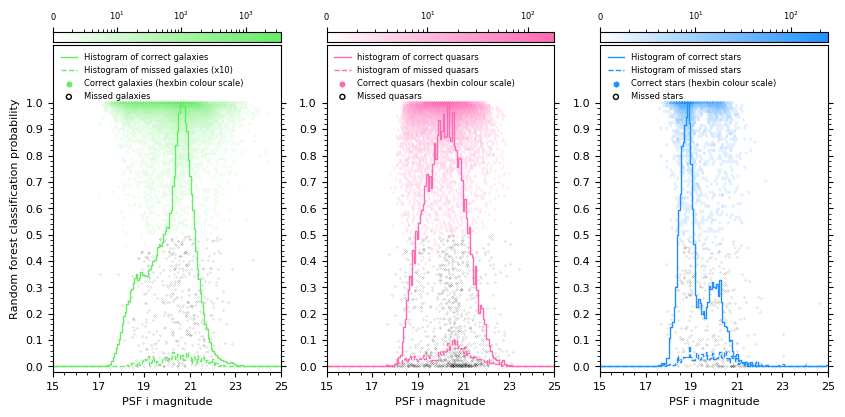

In [9]:
data_all, missed_star_all, missed_quasar_all, missed_galaxy_all, correct_star_all, correct_quasar_all, correct_galaxy_all, missed_star_as_quasar_all, missed_star_as_galaxy_all, missed_quasar_as_star_all, missed_quasar_as_galaxy_all, missed_galaxy_as_star_all, missed_galaxy_as_quasar_all = prepare_classifications(data_prep_dict_all, classes_pred_all)

plot_trainvsf1('train_vs_f1score', 'train_vs_f1score_sampleG', 'train_vs_precision', 'train_vs_precision_sampleG', 'train_vs_recall', 'train_vs_recall_sampleG', place)

plot_feature_ranking(pipeline, feature_labels, place)

plot_basic_hists(df, place)

plot_feature_hist(df, missed_star_all, missed_quasar_all, missed_galaxy_all, correct_star_all, correct_quasar_all, correct_galaxy_all, missed_star_as_quasar_all, missed_star_as_galaxy_all, missed_quasar_as_star_all, missed_quasar_as_galaxy_all, missed_galaxy_as_star_all, missed_galaxy_as_quasar_all, place, plot_data_label='')

plot_probs_hist(df, missed_star_all, missed_quasar_all, missed_galaxy_all, correct_star_all, correct_quasar_all, correct_galaxy_all, missed_star_as_quasar_all, missed_star_as_galaxy_all, missed_quasar_as_star_all, missed_quasar_as_galaxy_all, missed_galaxy_as_star_all, missed_galaxy_as_quasar_all, place, plot_data_label='_test')

class_prob_dic = {"GALAXY":"prob_g","STAR":"prob_s", "QSO":"prob_q"}
for class_pred, prob in class_prob_dic.items():
    df_no_nan = df.loc[~np.isnan(df[prob])]
    rate_99 = len(df_no_nan.loc[(df_no_nan[prob].values> 0.99)])/len(df_no_nan.loc[(df_no_nan.class_pred == class_pred)])
    rate_90 = len(df_no_nan.loc[(df_no_nan[prob].values> 0.90)])/len(df_no_nan.loc[(df_no_nan.class_pred == class_pred)])
    print('{2} 99以上: {0}%  {2} 90以上:{1}%'.format(round(rate_99*100, 2), round(rate_90*100, 2), class_pred))

plot_probs_hexscatter(df, missed_star_all, missed_quasar_all, missed_galaxy_all, correct_star_all, correct_quasar_all, correct_galaxy_all, missed_star_as_quasar_all, missed_star_as_galaxy_all, missed_quasar_as_star_all, missed_quasar_as_galaxy_all, missed_galaxy_as_star_all, missed_galaxy_as_quasar_all, place, plot_data_label='')



## 誤分類された天体の傾向を見つける

In [10]:
place = "psf_ishape_color"
df = load_obj('HSC_ML_save/'+place+'/df_spec_classprobs')

# クエーサーとして間違えられた銀河
df_G_q = df.loc[(df["class"]=="GALAXY") & (df["class_pred"]=="QSO"), ["ra","dec","class", "class_pred"]]

# 星として間違えられた銀河
df_G_s = df.loc[(df["class"]=="GALAXY") & (df["class_pred"]=="STAR"), ["ra","dec","class", "class_pred"]]

# 銀河として間違えられた星
df_S_g = df.loc[(df["class"]=="STAR") & (df["class_pred"]=="GALAXY"), ["ra","dec","class", "class_pred"]]

# クエーサーとして間違えられた星
df_S_q = df.loc[(df["class"]=="STAR") & (df["class_pred"]=="QSO"), ["ra","dec","class", "class_pred"]]

# 銀河と間違えられたクエーサー
df_Q_g = df.loc[(df["class"]=="QSO") & (df["class_pred"]=="GALAXY"), ["ra","dec","class", "class_pred"]]

# 星と間違えられたクエーサー
df_Q_s = df.loc[(df["class"]=="QSO") & (df["class_pred"]=="STAR"), ["ra","dec","class", "class_pred"]]